In [48]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt

import numpy as np

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import *

import pymc3 as pm
import theano
import theano.tensor as tt

import arviz as az

numpyro.enable_x64(True)
numpyro.set_host_device_count(4)

In [2]:
print("numpyro version: ", numpyro.__version__)
print("jax version: ", jax.__version__)
print("pymc3 version: ", pm.__version__)
print("theano version: ", theano.__version__)

numpyro version:  0.6.0
jax version:  0.2.10
pymc3 version:  3.9.0
theano version:  1.0.5


In [3]:
A = np.load("A.npy")
P2Y = np.load("P2Y.npy")
fo = np.load("f.npy")
ferr = np.load("ferr.npy")

n = P2Y.shape[1]

In [147]:
# PyMC3 model
with pm.Model() as model_pm:
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    fs = PositiveNormal("fs", mu=0.0, sigma=1.0)
    p_scale = PositiveNormal("p_scale", mu=0.0, sigma=1e-04)
    p = pm.Exponential("p", 1 / p_scale, shape=(n,))

    x = tt.dot(P2Y, p)
    pm.Deterministic("x", x)

    f = tt.dot(A, x[:, None]).flatten() + fs
    pm.Deterministic("f", f)

    obs = pm.Normal("obs", mu=f, sigma=ferr, observed=fo)
    

In [148]:
init_vals = {"p": 1e-06 * np.random.rand(n), "fs": 0.99999, "p_scale": 2e-05}

nwarmup = 500
nsamples = 500
nchains = 2

with model_pm:
    samples_pm = pm.sample(
        tune=nwarmup,
        draws=nsamples,
        cores=nchains,
        chains=nchains,
        target_accept=0.95,
        start=init_vals,
        init="adapt_diag",
    )
    samples_pm_az = az.from_pymc3(samples_pm)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p, p_scale, fs]
INFO:pymc3:NUTS: [p, p_scale, fs]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 221 seconds.
INFO:pymc3:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 221 seconds.


In [149]:
# Evaluate total log probability at each sample
logp = model_pm.logp
lnp_pm = np.array([logp(samples_pm.point(i,chain=c)) for c in samples_pm.chains for i in range(len(samples_pm))])

In [164]:
# Numpyro model
def model_num():
    fs = numpyro.sample("fs", dist.HalfNormal(scale=1.0))
    p_scale = numpyro.sample("p_scale", dist.HalfNormal(scale=1e-04))
    p = numpyro.sample("p", dist.Exponential(1 / p_scale).expand([n]))

    x = jnp.dot(P2Y, p)
    numpyro.deterministic("x", x)

    f = jnp.dot(A, x[:, None]).flatten() + fs
    numpyro.deterministic("f", f)

    numpyro.sample("obs", dist.Normal(f, ferr), obs=fo)
    
init_vals2 = {"p": samples_pm['p'][-1], "fs": samples_pm['fs'][-1], "p_scale": samples_pm['p_scale'][-1]}

nuts_kernel = NUTS(
    model_num,
    dense_mass=False,
    init_strategy=init_to_value(values=init_vals2),
    target_accept_prob=0.95,
)
mcmc = MCMC(nuts_kernel, num_warmup=nwarmup, num_samples=nsamples, num_chains=nchains)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, extra_fields=("potential_energy",))
samples_num_az = az.from_numpyro(mcmc)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [180]:
# Total log probability for the numpyro model 
lnp_num = -mcmc.get_extra_fields()["potential_energy"]

# Log likelihood for both models
ll_pm = np.sum(samples_pm_az.log_likelihood['obs'].data, axis=2).flatten()
ll_num = np.sum(samples_num_az.log_likelihood['obs'].data, axis=2).flatten()

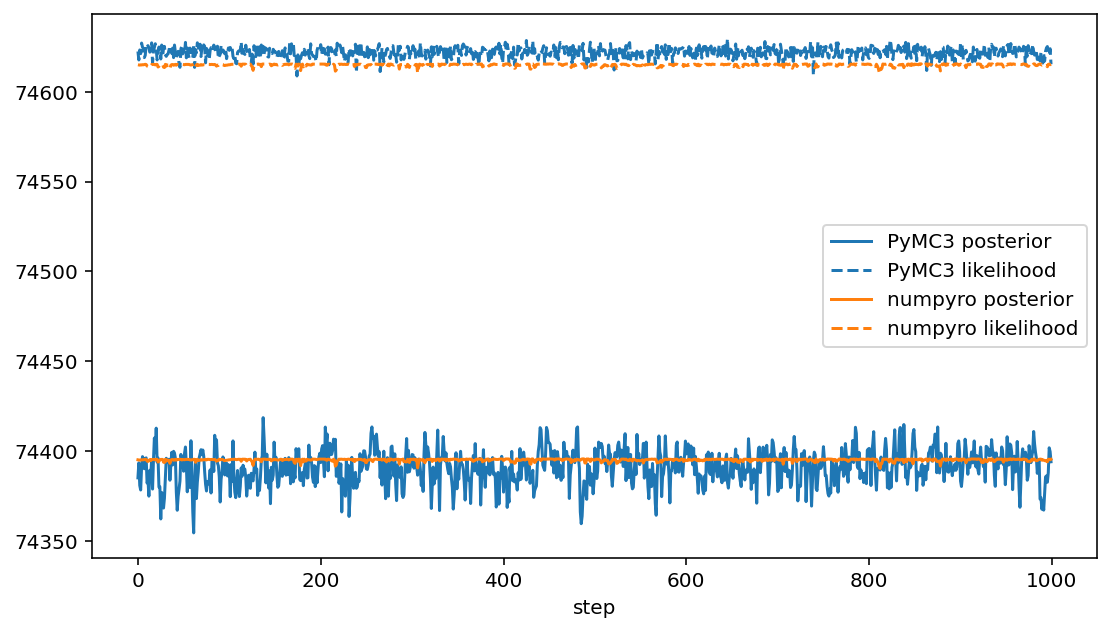

In [183]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(lnp_pm, 'C0-', label='PyMC3 posterior')
ax.plot(ll_pm, 'C0--', label='PyMC3 likelihood')
ax.plot(lnp_num, 'C1-', label='numpyro posterior')
ax.plot(ll_num, 'C1--', label='numpyro likelihood')
ax.set(xlabel='step')
ax.legend()

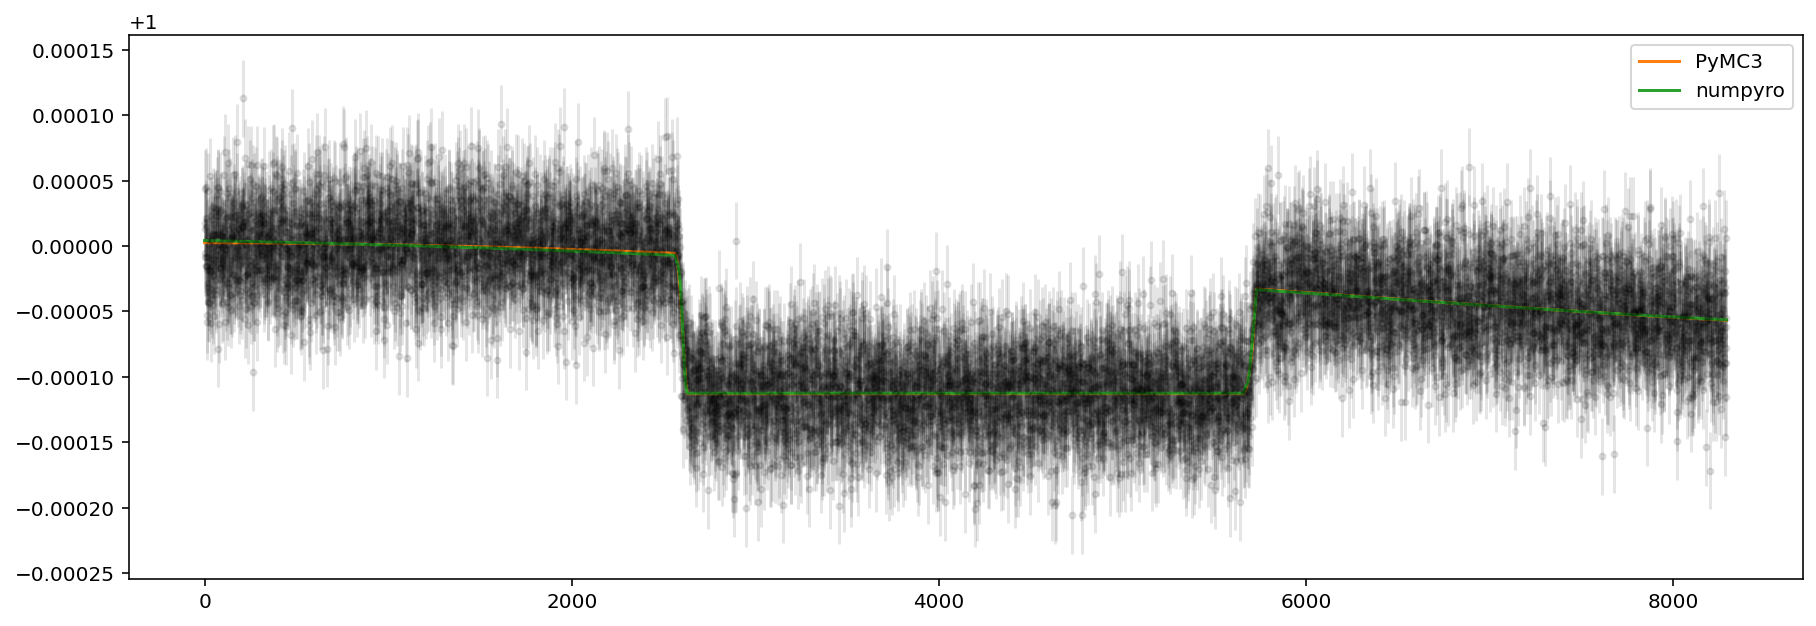

In [167]:
# Median model in data space
stacked_pm = samples_pm_az.posterior.stack(draws=("chain", "draw"))
stacked_num = samples_num_az.posterior.stack(draws=("chain", "draw"))
f_median_pm = np.median(stacked_pm['f'].data, axis=1)
f_median_num = np.median(stacked_num['f'].data, axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
ax.errorbar(np.arange(len(fo)), fo, ferr, marker='.', linestyle='', alpha=0.1, color='black')
ax.plot(np.arange(len(fo)), f_median_pm, 'C1-', label='PyMC3')
ax.plot(np.arange(len(fo)), f_median_num, 'C2-', label='numpyro')
ax.legend()

In [168]:
az.summary(samples_num_az, var_names=['x'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x[0],0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,22.0,1.96
x[1],0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,11.0,2.21
x[2],0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,11.0,1.84
x[3],-0.0,0.0,-0.0,-0.0,0.0,0.0,2.0,2.0,3.0,12.0,2.22
x[4],0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,11.0,2.15
x[5],0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,21.0,2.23
x[6],0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,11.0,2.06
x[7],0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,11.0,2.35
x[8],-0.0,0.0,-0.0,-0.0,0.0,0.0,2.0,2.0,3.0,15.0,2.15
x[9],-0.0,0.0,-0.0,-0.0,0.0,0.0,5.0,5.0,5.0,32.0,1.34


In [171]:
az.summary(samples_pm_az, var_names=['x'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x[0],0.0,0.0,0.0,0.0,0.0,0.0,1010.0,1002.0,1017.0,855.0,1.00
x[1],-0.0,0.0,-0.0,0.0,0.0,0.0,1296.0,1123.0,1297.0,852.0,1.00
x[2],-0.0,0.0,-0.0,-0.0,0.0,0.0,1127.0,1102.0,1172.0,847.0,1.00
x[3],-0.0,0.0,-0.0,-0.0,0.0,0.0,1587.0,1552.0,1583.0,835.0,1.00
x[4],0.0,0.0,-0.0,0.0,0.0,0.0,1514.0,842.0,1510.0,941.0,1.00
x[5],0.0,0.0,-0.0,0.0,0.0,0.0,1650.0,1077.0,1619.0,1022.0,1.00
x[6],0.0,0.0,0.0,0.0,0.0,0.0,1560.0,1392.0,1574.0,898.0,1.00
x[7],0.0,0.0,0.0,0.0,0.0,0.0,1602.0,1568.0,1568.0,902.0,1.00
x[8],-0.0,0.0,-0.0,0.0,0.0,0.0,1154.0,973.0,1156.0,985.0,1.00
x[9],0.0,0.0,-0.0,0.0,0.0,0.0,1757.0,908.0,1555.0,1027.0,1.00
